In [1]:
# The tools I learned from the course before this project

In [2]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import pickle


In [3]:
# read mtx and dist from saved pickle file
openFileName = './camera_cal/PRJ2_JLI_mtx_dist_pickle.p'
dist_pickle = pickle.load( open( openFileName, "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [4]:
def cal_undistort(img,mtx,dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

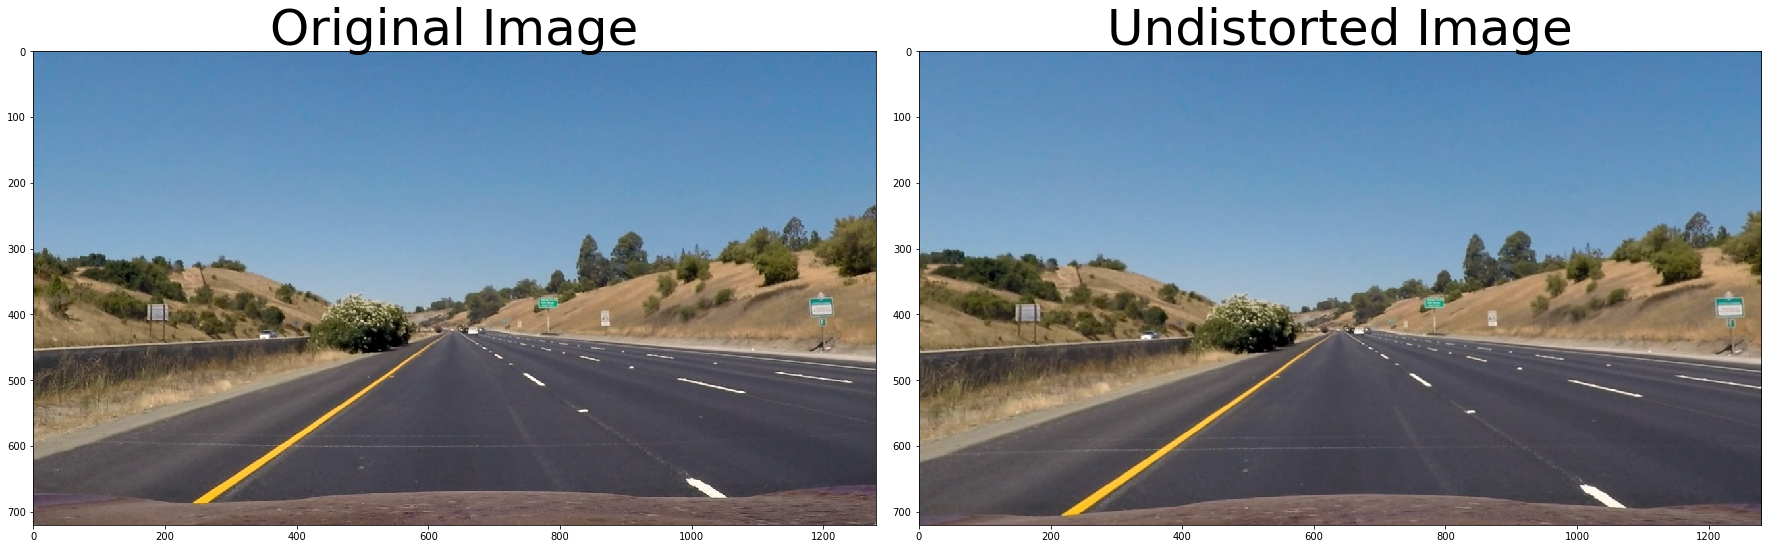

In [5]:
# Read in images
image_0 = mpimg.imread('./test_images/straight_lines1.jpg')
image = cal_undistort(image_0,mtx,dist)

# Print image in parellel
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_0)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [6]:
# Gradient, sobel x or y
# Define a function that takes an image, gradient orientation,
def abs_sobel_thresh(img, orient='x', sobel_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1

    # Return the result
    return binary_output

In [7]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


In [8]:
# combain S channel of HLS and sobel x
hls_binary = hls_select(image, thresh=(180, 255))
grad_binary_x = abs_sobel_thresh(image, orient='x', sobel_thresh=(20, 100))
combined_binary = np.zeros_like(hls_binary)
combined_binary[(hls_binary ==1)|(grad_binary_x==1)]=1

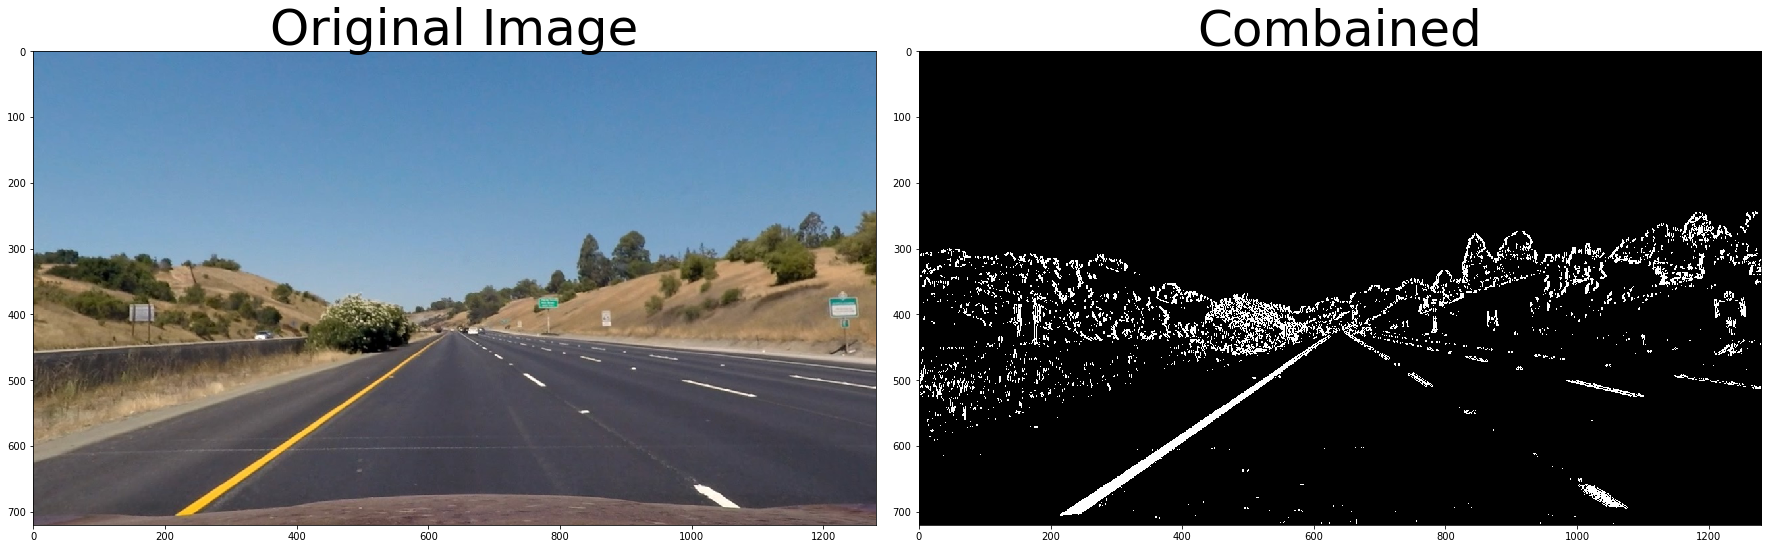

In [9]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combained', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [10]:
# image processing funciton return 1d fitting line overlay
# only one argument is used because of clipInput.fl_image
import math
def process_image(image): 

    # define parameter for line length
    vehicleHood = 1      # avoid vhhicle hood yGridMax*vehicleHood any line about this number get ingored
                         # only used for 3d fitting
    centerBrake = 0.05   # apex distance
    lineWidth = 15       # red lain width
    
    # make gray
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 7
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    
    # Define the parameters for Canny and apply
    low_threshold = 30
    high_threshold = 90
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)    
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   
    
    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    xGridMax = imshape[1]; # x max
    yGridMax = imshape[0]; # Y max
    yCo = 1.8 # smaller than 2 mean the top of the trapeziod is lower than the image center
              # yGridMax/yCo
    vertices = np.array([[(0,yGridMax), (xGridMax*(0.5-centerBrake), yGridMax/yCo), (xGridMax*(0.5+centerBrake), yGridMax/yCo),
                          (xGridMax,yGridMax)]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    #plt.imshow(masked_edges)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1                       # distance resolution in pixels of the Hough grid
    theta = np.pi/180             # angular resolution in radians of the Hough grid
    threshold = 15                # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 6           # minimum number of pixels making up a line
    max_line_gap = 10             # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    
    # Iterate over the output "lines" and draw lines on a blank image
    # use the slpoe to filter out the lateral lines
    # find ploy fit for left and right line seperately
    # try both first and thrid order polynomial fitting
    # sweep the x pixels by incriement of 5
    # filter out the out of range points 
    # draw the line using the polynomial
    slopeList = [ ] # list of slope detetec after hough transfer
    slope_left = [ ] # slope for the left lane
    slope_right = [ ] # slope for the right lane
    leftLine = [ ] # left line [x,y] 2D array
    rightLine = [ ] # right line [x,y] 2D array
    # iterate all line in _lines_
    for line in lines:
        # each line has a array [x1,y1,x2,y2]
        for x1,y1,x2,y2 in line:
            dy = y2 - y1
            dx = x2 - x1
            # file slope
            slope = dy / dx
            # only consider the slope between 0.5 and 0.9
            if abs(slope)<0.9 and abs(slope)>0.5: # using gardian as a filter
                # add slope into _slopelist_ array
                slopeList.append(slope)
                # seperate left right points
                # find x1,y1
                temp = [line[0][0],line[0][1]]
                # left
                if temp[0] < (xGridMax*0.5):
                    leftLine.append(temp)
                # right
                else:
                    rightLine.append(temp)
                # find x2,y2
                temp = [line[0][2],line[0][3]]
                # left
                if temp[0] < (xGridMax*0.5):
                    leftLine.append(temp)
                # right
                else:
                    rightLine.append(temp)
                # draw benchmark line
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
 
    # ploy fit
    # create points [[x1,y1],[x2,y2],...,[xn,yn]]
    leftLineX,leftLineY = zip(*leftLine)
    rightLineX,rightLineY = zip(*rightLine)
    
    # 1st order
    leftLineK1 = np.polyfit(leftLineX,leftLineY,1)
    print("leftLineK1",leftLineK1)
    rightLineK1 = np.polyfit(rightLineX,rightLineY,1)
    print("rightLineK1",rightLineK1)
    # result [k,b]
    # y = kx + b
    
  
    # 3rd order
    leftLineK = np.polyfit(leftLineX,leftLineY,3)
    rightLineK = np.polyfit(rightLineX,rightLineY,3)
    # result formate [a,b,c,d]
    # y = ax^3 + bx^2 + cx^1 + d
    
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 
    
    # first order fitting
    line_image_2 = np.copy(image)*0 # creating a blank to draw lines on
    # x sweep
    ix = 0
    leftXmin = xGridMax
    leftXmax = 0
    rightXmin = xGridMax
    rightXmax = 0
    while (ix<xGridMax):
        x1 = ix
        x2 = ix+1
        # left line
        if x1 < (xGridMax*(0.5-centerBrake)):
           # find y
            y1 = leftLineK1[0]*math.pow(x1,1)+leftLineK1[1]
            y1 = int(y1)
            y2 = leftLineK1[0]*math.pow(x2,1)+leftLineK1[1]
            y2 = int(y2)
            # remove y out of the image frame
            if y1 < yGridMax:
                # crate left line
                cv2.line(line_image_2,(x1,y1),(x2,y2),(255,0,0),lineWidth)
                if x1<leftXmin:
                    leftXmin = x1
                if x1>leftXmax:
                    leftXmax = x1
        # right line      
        elif x2 > (xGridMax*(0.5+centerBrake)):
                # print(x1,x2)
                # fine y
                y1 = rightLineK1[0]*math.pow(x1,1)+rightLineK1[1]
                y1 = int(y1)
                y2 = rightLineK1[0]*math.pow(x2,1)+rightLineK1[1]
                y2 = int(y2)
                # remove y out of the image frame
                if y2 < yGridMax:
                    # print(x1,y1,x2,y2)
                    # crate right line
                    cv2.line(line_image_2,(x1,y1),(x2,y2),(255,0,0),lineWidth)
                    if x1<rightXmin:
                        rightXmin = x1
                    if x1>rightXmax:
                        rightXmax = x1
        # next ix
        ix = ix+1
         
    # overlay pictures
    lines_edges = cv2.addWeighted(image, 1, line_image, 0.9, 0)     # origional
    lines_edges_2 = cv2.addWeighted(image, 1, line_image_2, 0.9, 0) # 1d fitting
    
    plt.show(block=True) # show image
    return lines_edges_2,leftLineK1,rightLineK1, leftXmax,leftXmin,rightXmax,rightXmin# return the 1st order fitting

leftLineK1 [ -6.98051707e-01   8.63029437e+02]
rightLineK1 [ 0.64394708  7.13139204]
[ -6.98051707e-01   8.63029437e+02]
[ 0.64394708  7.13139204]
left x max  575
left x min  205
right x max  1106
right x min  704


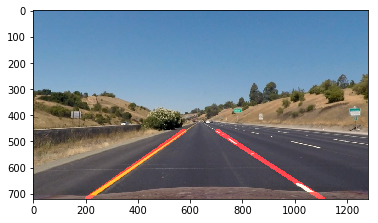

In [11]:
lines_edges_2,leftLineK1,rightLineK1, leftXmax,leftXmin,rightXmax,rightXmin = process_image(image)

plt.imshow(lines_edges_2)
print(leftLineK1) # left k and b
print(rightLineK1) # right k and b
print("left x max ",leftXmax) # left x max
print("left x min ",leftXmin) # left x min
print("right x max ",rightXmax) # right x max
print("right x min ",rightXmin) # right x min

[205, 719] [580, 461] [702, 460] [1106, 719]
[305, 720] [305, 0] [1006, 0] [1006, 720]
(720, 1280, 3)
(720, 1280, 3)


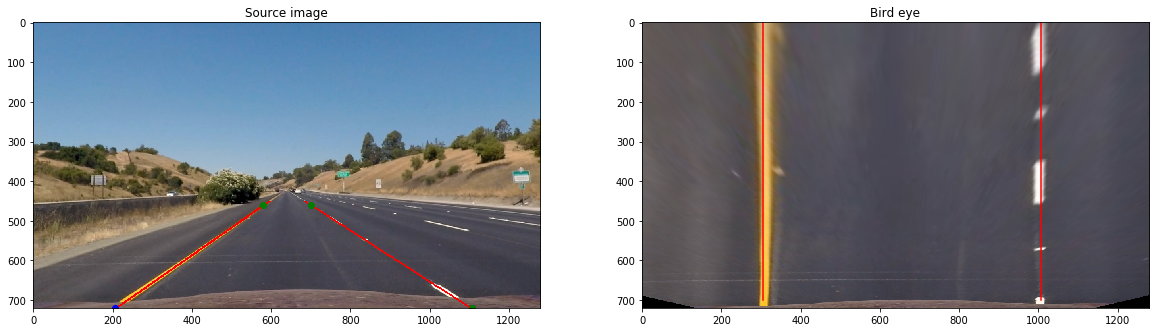

In [12]:
# Transfer wrap the image
imshape = image.shape
xGridMax = imshape[1]; # x max
yGridMax = imshape[0]; # Y max
yCo = 1.5 # smaller than 2 mean the top of the trapeziod is lower than the image center
            # yGridMax/yCo
XMargin = 150
centerBrake = 0.1   # apex distance
x1 = leftXmin
x2 = leftXmax
x3 = rightXmin
x4 = rightXmax

y1 = int(leftLineK1[0]*x1 + leftLineK1[1])
y2 = int(leftLineK1[0]*x2 + leftLineK1[1])
y3 = int(rightLineK1[0]*x3 + rightLineK1[1])
y4 = int(rightLineK1[0]*x4 + rightLineK1[1])

leftLength = math.sqrt((y2-y1)**2+(x2-x1)**2)
rightLength = math.sqrt((y4-y3)**2+(x4-x3)**2)

p1 = [x1,y1]
p2 = [x2+5,y2]
p3 = [x3-2,y3]
p4 = [x4,y4]
print(p1,p2,p3,p4)

# leave some room for the curve
# bird eye for three lanes
dx1 = x1 +100
dx4 = x4 -100

dp1 = [dx1,720]
dp2 = [dx1,0]
dp3 = [dx4,0]
dp4 = [dx4,720]
print(dp1,dp2,dp3,dp4)

#dShape = (xGridMax,np.int(yGridMax//yCo))
dShape = (imshape[1],imshape[0])

src = np.float32([p1,p2,p3,p4])
dst = np.float32([dp1,dp2,dp3,dp4])

m = cv2.getPerspectiveTransform(src,dst)
minv = cv2.getPerspectiveTransform(dst, src)

warped = cv2.warpPerspective(image, m, dShape, flags = cv2.INTER_LINEAR)

# left straight line in prespective view
line_image = np.copy(image)
XX, YY = np.meshgrid(np.arange(0, xGridMax), np.arange(0, yGridMax))
left_thresholds = (YY > (leftLineK1[0]*(XX) + leftLineK1[1])) & \
                  (YY < (leftLineK1[0]*(XX) + leftLineK1[1])+6) & \
                  (YY > (0*(XX) + yGridMax/1.6))
rigth_thresholds = (YY > (rightLineK1[0]*(XX) + rightLineK1[1])) & \
                  (YY < (rightLineK1[0]*(XX) + rightLineK1[1])+5) & \
                  (YY > (0*(XX) + yGridMax/1.6))
line_image[left_thresholds | rigth_thresholds ] = [255,0,0]

f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.set_title('Source image')
ax1.imshow(line_image)
ax1.plot(p1[0],p1[1],'bo')
ax1.plot(p2[0],p2[1],'go')
ax1.plot(p3[0],p3[1],'go')
ax1.plot(p4[0],p4[1],'go')

ax2.set_title('Bird eye')
ax2.imshow(warped,cmap='gray')
#ax2.plot(dp1[0],dp1[1],'bo')
#ax2.plot(dp2[0],dp2[1],'go')
#ax2.plot(dp3[0],dp3[1],'go')
#ax2.plot(dp4[0],dp4[1],'go')

# Vertical line in the top view left
xTop = np.linspace(0,yGridMax-20)
yTop = np.copy(xTop)*0+dx1
ax2.plot(yTop,xTop,'red')
# Vertical line in the top view right
xTop = np.linspace(0,yGridMax-20)
yTop = np.copy(xTop)*0+dx4

ax2.plot(yTop,xTop,'red')
plt.savefig('./test_images/straight_lines1_top_view_JLI.jpg')

print(line_image.shape)
print(warped.shape)

In [13]:
# Find relation ship between pixle and distacne
# Assuming x lane line width is 3.7m
ym_per_pix = 30/720       # meters per pixel in y dimension
xm_per_pix = 3.7/(x4-x1)  # meters per pixel in x dimension
# print("x meter per pixle is: ",xm_per_pix)
# print("y meter per pixle is: ",ym_per_pix)

In [14]:
# save pickle for this m and minv for later use
# save the camera calibretaion result for later use
dist_pickle = {}
dist_pickle["m"] = m # src to det 
dist_pickle["minv"] = minv # det to src
dist_pickle["ym_per_pix"] = ym_per_pix # y meter per pixle
dist_pickle["xm_per_pix"] = xm_per_pix # x meter per pixle
dist_pickle["leftLineK1"] = leftLineK1 # Left lane line
dist_pickle["rightLineK1"] = rightLineK1 # x right lane line


pickle.dump(dist_pickle,open("JLI_p_t_transfer.p","wb"))

print('Pickle file saved! \nFile name is: JLI_p_t_transfer.p')

Pickle file saved! 
File name is: JLI_p_t_transfer.p


In [15]:
# line finding method: Peaks in a histogram
def hist(img):
    # Grab only the bottom half of the image
    bottom_half = img[img.shape[0]//2:,:]
    # Lane lines are likely to be mostly vertical nearest to the car
    # Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

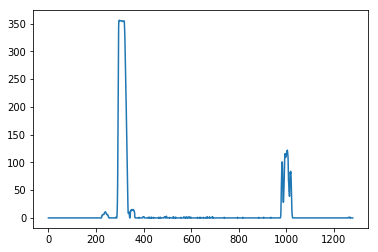

In [16]:
# Create histogram of image binary activations
warped = cv2.warpPerspective(combined_binary, m, dShape, flags = cv2.INTER_LINEAR)
histogram = hist(warped)
# Visualize the resulting histogram
plt.plot(histogram)
plt.show()

In [17]:
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint]) # x for highest y
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print(leftx_base)
print(rightx_base)

299
1004


640.0
655.5
-15.5
-0.06
0.49278579356270813


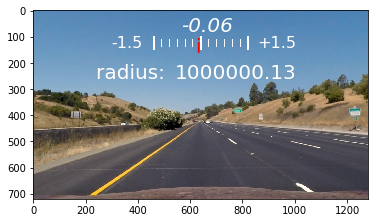

In [29]:
# find center to lane line distacne
xCenter = xGridMax/2
laneCenter = (x4+x1)/2
pixDet = xCenter-laneCenter # negtive car is on the left of the lane center
mDet = pixDet*xm_per_pix
imagePD = 1.5/180 # width fro
co = xm_per_pix/imagePD
print(xCenter)
print(laneCenter)
print(pixDet)
print("%.2f" % mDet)
print(co)

radius = 1000000.1321659416546

plt.imshow(image)
plt.text(xCenter-75,80,"%.2f" % mDet,color='w',size=20,style='oblique')
plt.text(xCenter-10,150,"I",color='w',size=20)
plt.text(xCenter+30*6-10,150,"I",color='w',size=20)
plt.text(xCenter-30*6-10,150,"I",color='w',size=20)
for i in range(5):
    plt.text(xCenter+30*(i+1)-5,135,"I",color='w',size=10) # 150 tital
    plt.text(xCenter-30*(i+1)-5,135,"I",color='w',size=10)
plt.text(xCenter+30*6-10+45,140,"+1.5",color='w',size=16)
plt.text(xCenter-30*6-10-150,140,"-1.5",color='w',size=16)
plt.text(xCenter-12+pixDet*co,160,"i",color='r',size=20)

plt.text(xCenter-400,260,"radius: ",color='w',size=20)
plt.text(xCenter-100,260,"%.2f" % radius ,color='w',size=20)

plt.savefig("distacne.jpg")